# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [2]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [3]:
# Install requirements
!python -m pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 11.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... |^C
anceled
ERROR: Operation cancelled by user


## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [15]:
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [24]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5), (.5))])

# Create training set and define training dataloader
train_data = datasets.MNIST(root='data/', download=True, train=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=250, shuffle=True)

# Create test set and define test dataloader
test_val_data = datasets.MNIST(root='data/', download=True, train=True, transform=transform)
val_size = int(len(test_val_data) / 2)
test_size = len(test_val_data) - val_size
val_data, test_data = random_split(test_val_data, [val_size, test_size])
test_loader = DataLoader(test_data, batch_size=250)
val_loader = DataLoader(val_data, batch_size=250)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I chose the transforms ToTensor and Normalize because, pytorch uses tensors input to train a model. So, I have to convert the input data to tensors. And Normalize because I want to have the pixel values of images similar scale and avoid any particular feature for dominating the learning process. It also ensures that the inputs have zero mean and unit variant and improve the training process and the performance of the model.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [25]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

9


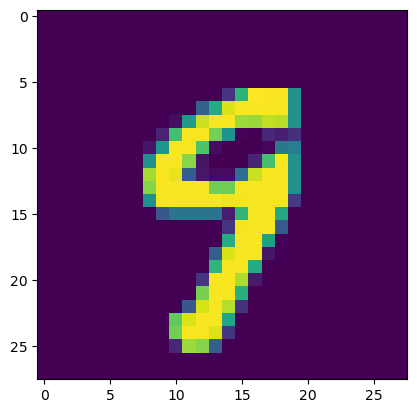

9


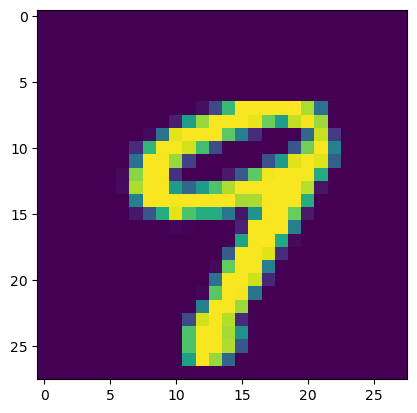

2


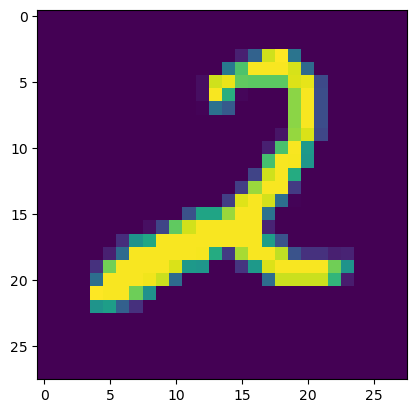

0


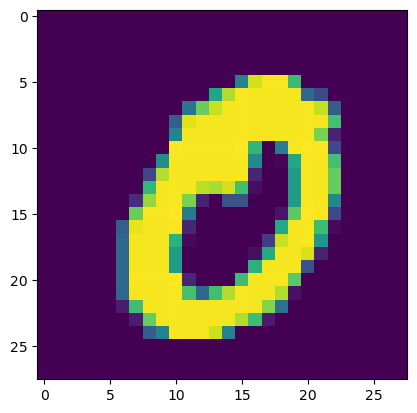

1


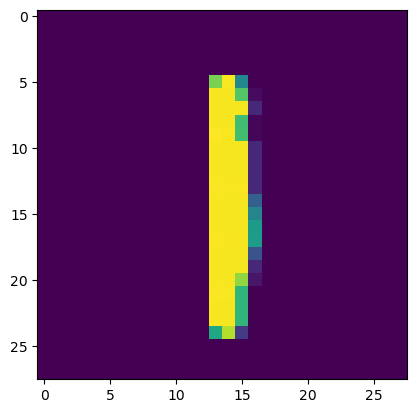

In [26]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [108]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28, 392)
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 98)
        self.fc4 = nn.Linear(98, 10)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        
        return x
        
network = Net()
network.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=392, bias=True)
  (fc2): Linear(in_features=392, out_features=196, bias=True)
  (fc3): Linear(in_features=196, out_features=98, bias=True)
  (fc4): Linear(in_features=98, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [109]:
optimizer = optim.Adam(network.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [110]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    # Establish a list for history
    train_loss_history = list()
    val_loss_history = list()
    
    for epoch in range(num_epochs):
        # in train mode
        model.train()
        train_loss = .0
        train_correct = 0
        
        for i, data in enumerate(train_loader):
            inputs, labels = data
            
            # Use GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Reset the gradient descent params to zero
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predictions = torch.max(outputs.data, 1)
            train_correct += (predictions == labels).float().mean().item()
            train_loss += loss.item()
            
        print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
        train_loss_history.append(train_loss/len(train_loader))
        
        
        val_loss = .0
        val_correct = 0
        
        # In Validation mode
        model.eval()
        
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss - criterion(outputs, labels)
            
            _, predictions = torch.max(outputs.data, 1)
            val_correct += (predictions == labels).float().mean().item()
            val_loss += loss.item()
            
        print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss  {val_loss/len(test_loader):.5f}')
        val_loss_history.append(val_loss/len(test_loader))
        
    return train_loss_history, val_loss_history

In [111]:
# Start training
train_loss_history, val_loss_history = train_model(network, train_loader, val_loader, optimizer, criterion, num_epochs=10)

Epoch 1 training accuracy: 0.61% training loss: 1.11593
Epoch 1 validation accuracy: 0.84% validation loss  0.62906
Epoch 2 training accuracy: 0.88% training loss: 0.37637
Epoch 2 validation accuracy: 0.89% validation loss  0.27110
Epoch 3 training accuracy: 0.91% training loss: 0.27280
Epoch 3 validation accuracy: 0.91% validation loss  0.21888
Epoch 4 training accuracy: 0.93% training loss: 0.20216
Epoch 4 validation accuracy: 0.93% validation loss  0.18153
Epoch 5 training accuracy: 0.95% training loss: 0.14920
Epoch 5 validation accuracy: 0.93% validation loss  0.18700
Epoch 6 training accuracy: 0.96% training loss: 0.13504
Epoch 6 validation accuracy: 0.92% validation loss  0.18671
Epoch 7 training accuracy: 0.96% training loss: 0.11364
Epoch 7 validation accuracy: 0.94% validation loss  0.10265
Epoch 8 training accuracy: 0.97% training loss: 0.09269
Epoch 8 validation accuracy: 0.94% validation loss  0.03057
Epoch 9 training accuracy: 0.98% training loss: 0.07009
Epoch 9 validati

Plot the training loss (and validation loss/accuracy, if recorded).

In [112]:
def plot_losses(train_loss_history, val_loss_history):
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.legend()
    plt.show()

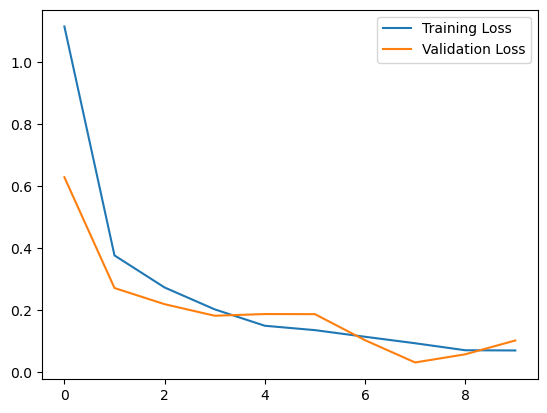

In [113]:
plot_losses(train_loss_history, val_loss_history)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [114]:
def test_model(model, test_loader):
    model.eval()
    test_correct = 0
    
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        _, predictions = torch.max(outputs.data, 1)
        test_correct += (predictions == labels).float().mean().item()
        
    print(f'Test accuracy: {test_correct / len(test_loader)}%')

In [115]:
# Start testing
test_model(network, test_loader)

Test accuracy: 0.9397666648030281%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [116]:
# Train the model with 5 more epoches 
train_loss_history, val_loss_history = train_model(network, train_loader, val_loader, optimizer, criterion, num_epochs=5)

Epoch 1 training accuracy: 0.98% training loss: 0.07126
Epoch 1 validation accuracy: 0.89% validation loss  0.07630
Epoch 2 training accuracy: 0.97% training loss: 0.09088
Epoch 2 validation accuracy: 0.94% validation loss  0.09005
Epoch 3 training accuracy: 0.98% training loss: 0.05884
Epoch 3 validation accuracy: 0.94% validation loss  0.07330
Epoch 4 training accuracy: 0.99% training loss: 0.04164
Epoch 4 validation accuracy: 0.95% validation loss  0.02585
Epoch 5 training accuracy: 0.99% training loss: 0.03588
Epoch 5 validation accuracy: 0.95% validation loss  0.06858


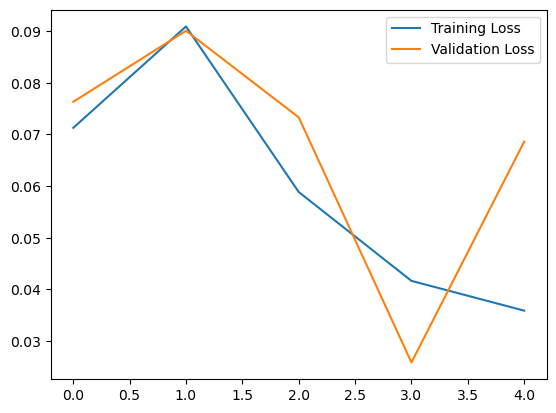

In [117]:
plot_losses(train_loss_history, val_loss_history)

In [118]:
test_model(network, test_loader)

Test accuracy: 0.9429666658242544%


## Saving your model
Using `torch.save`, save your model for future loading.

In [119]:
torch.save(network.state_dict(), 'model.pth')